In [1]:
import numpy as np
import processingIO as pio
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
from dataUtilities import filterData
from forceClass import Forces
from forceBinsClass import ForceBins

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [2]:
def power_law(xData, a, b, c):
        return a + (b * xData) + (c * xData**2)

def fit_data(xData, yData):

    popt, pcov = curve_fit(power_law, xData, yData, p0=[0.5, 0.5, 0.5])

    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)

    r_squared = 1 - (ss_res/ss_total)

    return popt, r_squared

In [3]:
data_location = r'D:\OpenFOAM_Simulations\fish_gridInd'

# Flags to handle data correctly
force_flag = 1
forceBin_flag = 0

force_paths = pio.get_files(data_location, 'force.dat')
force_paths.sort()
forceBins_paths = pio.get_files(data_location, 'forceBin.dat')
forceBins_paths.sort()


if force_flag==1:
    # get the individual cases
    cases = []
    force_case = force_paths[0].parts[-7]
    cases.append(force_case)
    for force_file in force_paths:
        if force_file.parts[-7] != force_case:
            cases.append(force_file.parts[-7])
            force_case = force_file.parts[-7]

    # get all the folders inside the cases
    strouhals = []
    for force_file in force_paths:
        if force_file.parts[-7] == cases[0]:
            strouhals.append(force_file.parts[-6])
        else:
            break

    # make a nice dict of all the file names based on parent case
    force_caseDict = dict()
    force_caseDict['Forces'] = {}
    for case in cases:
        force_caseDict['Forces'][case] = {}
        for force_file in force_paths:
            if force_file.parts[-7] == case:
                force_caseDict['Forces'][case][force_file.parts[-6]] = force_file

if forceBin_flag is True:
    # get the individual cases
    cases = []
    forceBin_case = forceBins_paths[0].parts[-7]
    cases.append(forceBin_case)
    for forceBins_file in forceBins_paths:
        if forceBins_file.parts[-7] != forceBin_case:
            cases.append(forceBins_file.parts[-7])
            forceBin_case = forceBins_file.parts[-7]

    # get the all the folders inside the cases
    strouhals = []
    for forceBins_file in forceBins_paths:
        if forceBins_file.parts[-7] == cases[0]:
            strouhals.append(forceBins_file.parts[-6])
        else:
            break

    # make a nice dict of all the file names based on parent case
    forceBin_caseDict = dict()
    forceBin_caseDict['ForceBins'] = {}
    for case in cases:
        forceBin_caseDict['ForceBins'][case] = {}
        for forceBins_file in forceBins_paths:
            if forceBins_file.parts[-7] == case:
                forceBin_caseDict['ForceBins'][case][forceBins_file.parts[-6]] = forceBins_file

In [4]:
if force_flag == 1:
    forces = [Forces(force_path, 2.0, 3.0, True, True) for force_path in force_paths]
if forceBin_flag == 1:
    forceBins = [ForceBins(forceBin_path, 2.0, 3.0, True, True) for forceBin_path in forceBins_paths]

In [5]:
density = 1025

average_force_dict = {}
for case in force_caseDict['Forces']:
    average_force_dict[case] = {'x':[], 'y':[]}
    for force in forces:
        if force.parent_case == case:
            average_force_dict[case]['x'].append(force.averageFilteredForces['total']['x']/density) 
            average_force_dict[case]['y'].append(force.averageFilteredForces['total']['y']/density)

In [6]:
average_force_dict

{'fish_grid_gmsh1': {'x': [-13.224545923803237], 'y': [55.2226133280644]},
 'fish_grid_gmsh2': {'x': [-8.403051529614178], 'y': [10.469121422054494]},
 'fish_grid_gmsh3': {'x': [-8.526125277707232], 'y': [7.63157952280779]},
 'fish_grid_snappy1': {'x': [-14.332616970627779], 'y': [52.8176196191412]},
 'fish_grid_snappy2': {'x': [-14.302456780912376], 'y': [17.78884839931719]},
 'fish_grid_snappy3': {'x': [-22.467600405747348], 'y': [14.949111914585103]}}

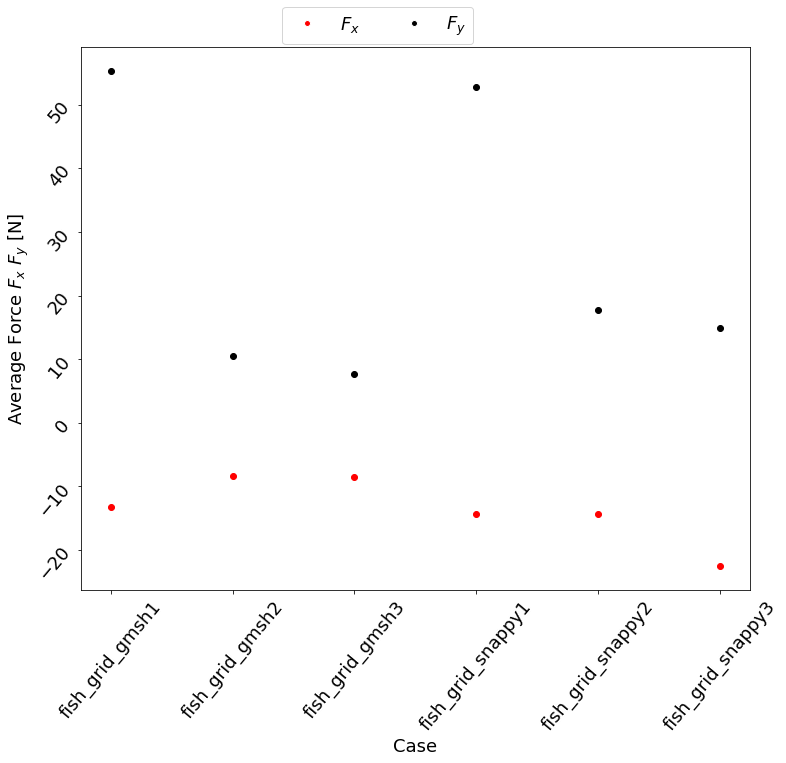

In [17]:
plt.rcParams.update({'font.size':18})
figure_location = r'/home/mco143/Documents/gitRepos/IkaFlow/OpenFOAM/figures'


fig1, ax1 = plt.subplots(figsize=(12,10))
for case in average_force_dict:
    ax1.plot(case, average_force_dict[case]['x'][0], 'ro')
    ax1.plot(case, average_force_dict[case]['y'][0], 'ko')

ax1.tick_params(rotation=50)
ax1.set_xlabel('Case')
ax1.set_ylabel('Average Force $F_x$ $F_y$ [N]')
custom_dots = [Line2D([0], [0], marker='o', color='w', markerfacecolor='r', label='$F_x$'),
               Line2D([0], [0], marker='o', color='w', markerfacecolor='k', label='$F_y$')]
ax1.legend(handles=custom_dots, ncol=2, bbox_to_anchor=(0.6, 1.09))
#fig2.savefig(Path(figure_location).joinpath('AvgPower_St.png'))

-13.224545923803237
-8.403051529614178
-8.526125277707232
-14.332616970627779
-14.302456780912376
-22.467600405747348
